# Air Traffic and Cargo System Time Series Analysis and Forecasting

## Import Libraries

In [6]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
from pandas import Series
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = (20, 10)
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from scipy import stats
from scipy.stats import normaltest
from time import strftime

## Read Data

In [2]:
df = pd.read_csv('<AIR_TRAFFIC_DATA>.csv', header = 0)

## Data Preprocessing

In [3]:
df['Month'] = pd.to_datetime(df['Month'], format = '%b-%y')
y = df.set_index('Month')

### Specify Data Frame Content

In [4]:
data = y.Aircraft_Total

### Divide Data into Training and Validation Sets

Validation Start Index: 2014-05-01 00:00:00
Validation End Index: 2019-10-01 00:00:00


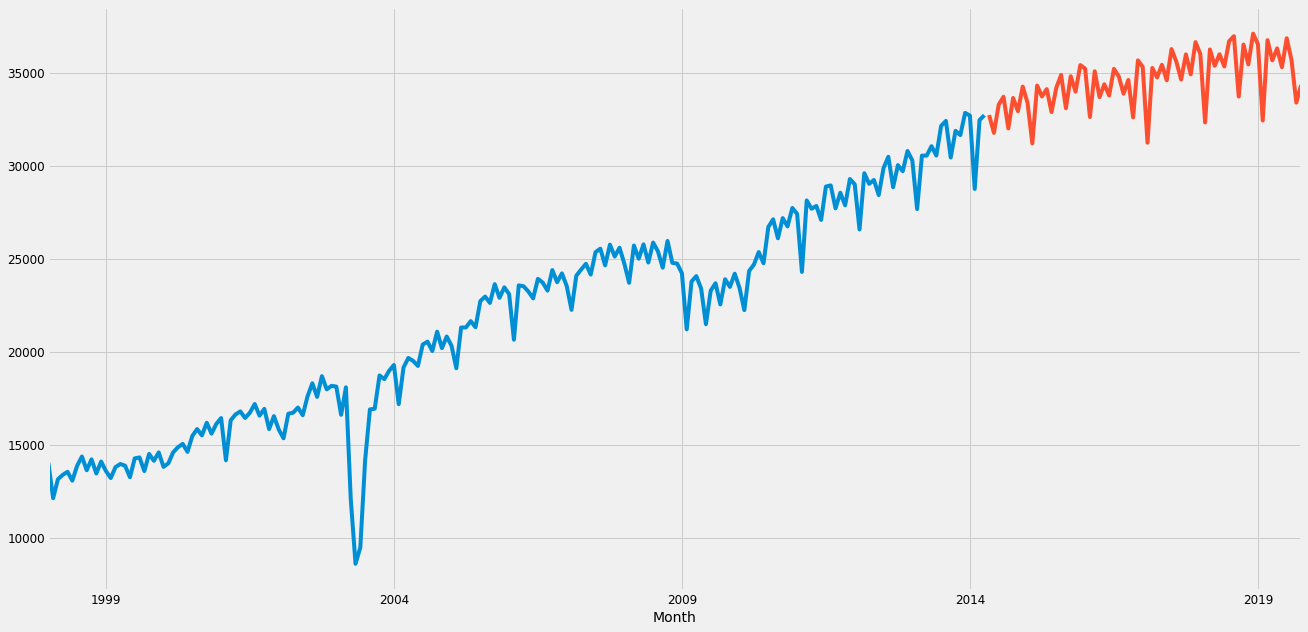

In [7]:
train = data[:int(0.75*(len(data)))]
valid = data[int(0.75*(len(data))):]
start_index = valid.index.min()
end_index = valid.index.max()

# Plotting the data
print('Validation Start Index: {}\nValidation End Index: {}'.format(start_index, end_index))
train.plot()
valid.plot()

## Time Series Forecast - Build the Model

### Function for Forecast Quality Scoring Metrics

In [8]:
# Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    
# Forecast Quality Scoring Metrics
def evaluate_forecast(y, pred):
    # R Squared
    results = pd.DataFrame({'R Squared':r2_score(y, pred)}, index = [0])
    # Mean Squared Error
    results['MSE'] = mean_squared_error(y, pred)
    # Root Mean Squared Error
    results['RMSE'] = np.sqrt(results['MSE'])
    # Mean Squared Logarithmic Error
    results['MSLE'] = mean_squared_log_error(y, pred)
    # Mean Absolute Error
    results['Mean Absolute Error'] = mean_absolute_error(y, pred)
    # Median Absolute Error
    results['Median Absolute Error'] = median_absolute_error(y, pred)
    # Mean Absolute Percentage Error
    results['MAPE'] = mean_absolute_percentage_error(y, pred)
    # Symmetric Mean Absolute Percentage Error
    results['SMAPE'] = symmetric_mean_absolute_percentage_error(y, pred)
    # Percentage of Mean Absolute Error
    results['MAE%'] = mean_absolute_error(y, pred)/np.mean(y)*100
    return results

### Function for Residual Diagnostics

In [9]:
def residual_diagnostics(fitted_model, alpha = 0.01, lag = 40):
    resid = fitted_model.resid
    print(normaltest(resid))
    print('====================================================================')
    if normaltest(resid).pvalue < alpha:
        print('p-value = %.4f. The residuals do not follow normal distribution.' % normaltest(resid).pvalue)
    else:
        print('p-value = %.4f. The residuals follow normal distribution.' % normaltest(resid).pvalue)
    print('====================================================================')

    fig = plt.figure()
    ax0 = fig.add_subplot(111)

    sns.distplot(resid, fit = stats.norm, ax = ax0)

    # Get the fitted parameters used by the function
    (mu, sigma) = stats.norm.fit(resid)

    # Plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc = 'best')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution')

    # ACF and PACF
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(fitted_model.resid, lags = lag, ax = ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(fitted_model.resid, lags = lag, ax = ax2)

### Auto SARIMA Adding External Variables

#### Holiday Factor By Month

#### 1. Import holiday data

In [10]:
holiday_v2 = pd.read_csv('<HOLIDAY_DATA>.csv', header = 0)[:-2]
#holiday_v2['date'] = pd.to_datetime(holiday_v2['date'], yearfirst = True, format = '%Y/%m/%d')
holiday_v2 = holiday_v2.set_index(['date'])
holiday_v2.index = pd.to_datetime(holiday_v2.index, yearfirst = True, format = '%Y/%m/%d')
holiday_v2.head()

,index,weekday,holiday,is_long_weekend,long_weekend_count,long_weekend_length
date,,,,,,
1998-01-01,1,Thursday,The first day of January,0,0,1
1998-01-28,2,Wednesday,Lunar New Year's Day,1,1,5
1998-01-29,3,Thursday,The second day of Lunar New Year,1,0,-1
1998-01-30,4,Friday,The third day of Lunar New Year,1,0,-1
1998-04-06,5,Monday,The day following Ching Ming Festival,1,1,3


#### 2. Group by month and calculate number of holidays per month

In [11]:
holiday_by_month = holiday_v2.groupby(pd.Grouper(freq='M')).sum()
holiday_by_month = holiday_by_month.drop(['index', 'long_weekend_length'], axis=1)
holiday_by_month['holiday_count'] = holiday_v2.groupby(pd.Grouper(freq='M'))[['holiday']].count()
holiday_by_month.head()

,is_long_weekend,long_weekend_count,holiday_count
date,,,
1998-01-31,3,1,4
1998-02-28,0,0,0
1998-03-31,0,0,0
1998-04-30,4,2,4
1998-05-31,0,0,1


#### 3. Check if it is summer or winter vacation for each month

In [12]:
holiday_by_month['is_summer_winter_vacation'] = [0] * len(holiday_by_month)

for i in range(len(holiday_by_month)):
    if holiday_by_month.index[i].month == 7 or holiday_by_month.index[i].month == 8 or holiday_by_month.index[i].month == 12 or holiday_by_month.index[i].month == 1:
        holiday_by_month['is_summer_winter_vacation'][i] = 1
    else:
        holiday_by_month['is_summer_winter_vacation'][i] = 0

holiday_by_month.head(12)

,is_long_weekend,long_weekend_count,holiday_count,is_summer_winter_vacation
date,,,,
1998-01-31,3,1,4,1
1998-02-28,0,0,0,0
1998-03-31,0,0,0,0
1998-04-30,4,2,4,0
1998-05-31,0,0,1,0
1998-06-30,0,0,0,0
1998-07-31,0,0,1,1
1998-08-31,1,1,1,1
1998-09-30,0,0,0,0


#### 4. Reindex and check if any long weekend exists for each month

In [13]:
holiday_by_month = holiday_by_month.set_index(data.index)
for i in range(len(holiday_by_month)):
    holiday_by_month['is_long_weekend'][i] = 0 if holiday_by_month['is_long_weekend'][i] == 0 else 1

holiday_by_month.head()

,is_long_weekend,long_weekend_count,holiday_count,is_summer_winter_vacation
Month,,,,
1998-01-01,1,1,4,1
1998-02-01,0,0,0,0
1998-03-01,0,0,0,0
1998-04-01,1,2,4,0
1998-05-01,0,0,1,0


#### 5. Create dummy variables according to length of long weekend

In [14]:
long_weekend_length = pd.get_dummies(holiday_v2, columns = ['long_weekend_length'], prefix = ['long_weekend_length'])
long_weekend_length = long_weekend_length.groupby(pd.Grouper(freq='M')).sum()
long_weekend_length = long_weekend_length.drop(['index', 'is_long_weekend', 'long_weekend_count', 'long_weekend_length_-1'], axis=1)
long_weekend_length = long_weekend_length.set_index(data.index)
long_weekend_length.head()

,long_weekend_length_0,long_weekend_length_1,long_weekend_length_2,long_weekend_length_3,long_weekend_length_4,long_weekend_length_5
Month,,,,,,
1998-01-01,0,1,0,0,0,1
1998-02-01,0,0,0,0,0,0
1998-03-01,0,0,0,0,0,0
1998-04-01,0,0,0,1,1,0
1998-05-01,1,0,0,0,0,0


#### 6. Split data into training and validation sets

In [15]:
exog_data_month = holiday_by_month.merge(long_weekend_length, how = 'left', on = 'Month')
exog_data_month.head(12)

,is_long_weekend,long_weekend_count,holiday_count,is_summer_winter_vacation,long_weekend_length_0,long_weekend_length_1,long_weekend_length_2,long_weekend_length_3,long_weekend_length_4,long_weekend_length_5
Month,,,,,,,,,,
1998-01-01,1,1,4,1,0,1,0,0,0,1
1998-02-01,0,0,0,0,0,0,0,0,0,0
1998-03-01,0,0,0,0,0,0,0,0,0,0
1998-04-01,1,2,4,0,0,0,0,1,1,0
1998-05-01,0,0,1,0,1,0,0,0,0,0
1998-06-01,0,0,0,0,0,0,0,0,0,0
1998-07-01,0,0,1,1,0,1,0,0,0,0
1998-08-01,1,1,1,1,0,0,0,1,0,0
1998-09-01,0,0,0,0,0,0,0,0,0,0


In [16]:
exog_data_month_train = exog_data_month[:len(train)]
exog_data_month_train.head(12)

,is_long_weekend,long_weekend_count,holiday_count,is_summer_winter_vacation,long_weekend_length_0,long_weekend_length_1,long_weekend_length_2,long_weekend_length_3,long_weekend_length_4,long_weekend_length_5
Month,,,,,,,,,,
1998-01-01,1,1,4,1,0,1,0,0,0,1
1998-02-01,0,0,0,0,0,0,0,0,0,0
1998-03-01,0,0,0,0,0,0,0,0,0,0
1998-04-01,1,2,4,0,0,0,0,1,1,0
1998-05-01,0,0,1,0,1,0,0,0,0,0
1998-06-01,0,0,0,0,0,0,0,0,0,0
1998-07-01,0,0,1,1,0,1,0,0,0,0
1998-08-01,1,1,1,1,0,0,0,1,0,0
1998-09-01,0,0,0,0,0,0,0,0,0,0


In [17]:
exog_data_month_valid = exog_data_month[len(train):]
exog_data_month_valid.head(12)

,is_long_weekend,long_weekend_count,holiday_count,is_summer_winter_vacation,long_weekend_length_0,long_weekend_length_1,long_weekend_length_2,long_weekend_length_3,long_weekend_length_4,long_weekend_length_5
Month,,,,,,,,,,
2014-05-01,0,0,2,0,0,2,0,0,0,0
2014-06-01,1,1,1,0,0,0,0,1,0,0
2014-07-01,0,0,1,1,0,1,0,0,0,0
2014-08-01,0,0,0,1,0,0,0,0,0,0
2014-09-01,0,0,1,0,0,1,0,0,0,0
2014-10-01,1,1,2,0,0,0,1,0,0,0
2014-11-01,0,0,0,0,0,0,0,0,0,0
2014-12-01,1,1,2,1,0,0,0,0,1,0
2015-01-01,0,0,1,1,0,1,0,0,0,0


##### Fit the model

In [18]:
%%time
model_Auto_SARIMA_ext_var_month = auto_arima(train, trace = True, error_action = 'ignore', suppress_warnings = True, seasonal = True, m = 12, stepwise = False, exogenous = exog_data_month_train)
model_Auto_SARIMA_ext_var_month_fit = model_Auto_SARIMA_ext_var_month.fit(train, exogenous = exog_data_month_train)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=3297.649, BIC=3336.925, Fit time=0.040 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=3275.926, BIC=3318.475, Fit time=1.512 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 2, 12); AIC=3266.836, BIC=3312.658, Fit time=3.874 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=3262.290, BIC=3304.839, Fit time=1.651 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 12); AIC=3236.721, BIC=3282.543, Fit time=1.789 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 2, 12); AIC=3239.578, BIC=3288.673, Fit time=4.147 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 0, 12); AIC=3251.168, BIC=3296.990, Fit time=3.906 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 12); AIC=3239.140, BIC=3288.235, Fit time=4.249 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 2, 12); AIC=3252.223, BIC=3304.591, Fit time=4.940 seconds
Fit ARIMA: order=(0, 1, 1) s

Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 0, 0, 12); AIC=3258.511, BIC=3314.152, Fit time=5.352 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=3277.014, BIC=3329.382, Fit time=1.020 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=3270.523, BIC=3326.164, Fit time=2.262 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 0, 12); AIC=3269.200, BIC=3324.841, Fit time=2.775 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 12); AIC=3282.320, BIC=3337.961, Fit time=1.065 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=3285.167, BIC=3334.262, Fit time=0.174 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=3267.149, BIC=3319.517, Fit time=1.581 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 0, 2, 12); AIC=3259.766, BIC=3315.407, Fit time=4.226 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=3256.870, BIC=3309.238, Fit time=2.005 seconds
Fit ARIMA: order=(3, 1, 0) s

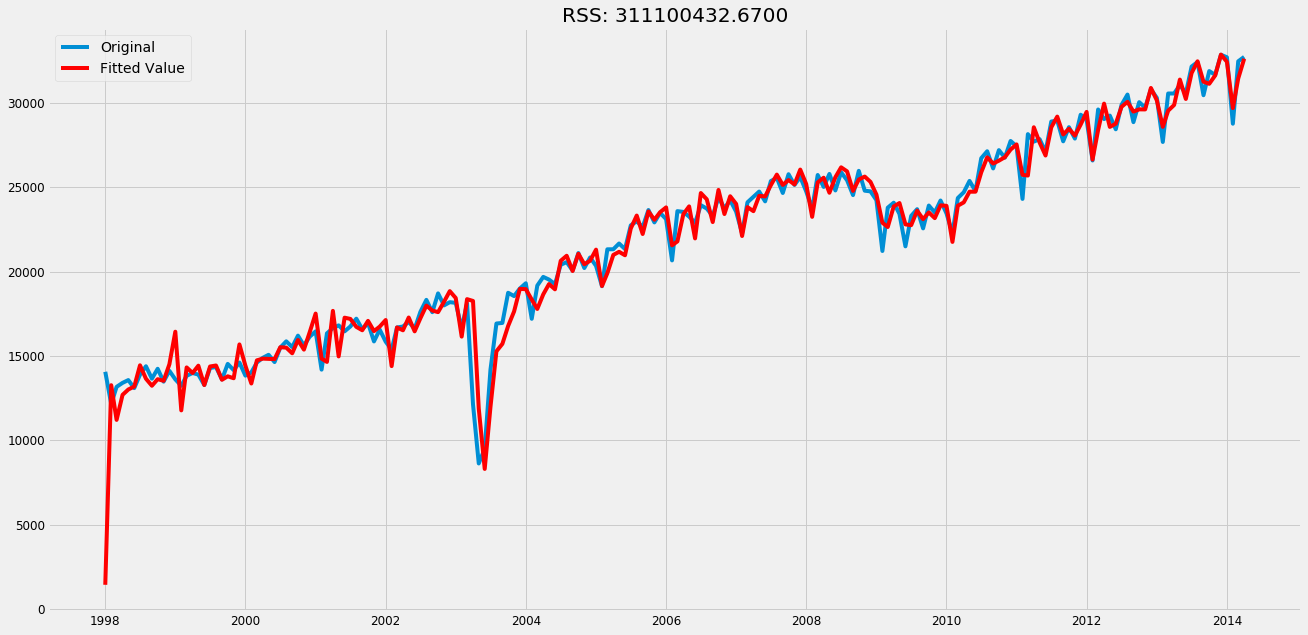

In [19]:
fitted_value_Auto_SARIMA_ext_var_month = pd.DataFrame(model_Auto_SARIMA_ext_var_month_fit.predict_in_sample(exogenous = exog_data_month_train), index = train.index, columns = ['Fitted Value'])
plt.plot(train, label='Original')
plt.plot(fitted_value_Auto_SARIMA_ext_var_month, color='red', label='Fitted Value')
plt.title('RSS: %.4f'% sum((model_Auto_SARIMA_ext_var_month_fit.predict_in_sample(exogenous = exog_data_month_train)-train)**2))
plt.legend()
plt.show()

In [20]:
model_Auto_SARIMA_ext_var_month_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  196
Model:             SARIMAX(3, 1, 0)x(1, 0, 1, 12)   Log Likelihood               -1599.118
Date:                            Tue, 04 Feb 2020   AIC                           3232.236
Time:                                    17:50:45   BIC                           3287.877
Sample:                                01-01-1998   HQIC                          3254.764
                                     - 04-01-2014                                         
Covariance Type:                              opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                    -3.2741     13.933     -0.235      0.814     -30.582      24.034
is_long_weekend            -460.2389    259.733     -1.772      0.076    -969.306      48.828
long_weekend_count          726.1484    396.325      1.832      0.067     -50.634    1502.930
holiday_count              -150.0788    125.061     -1.200      0.230    -395.193      95.036
is_summer_winter_vacation  1130.2156    451.497      2.503      0.012     245.297    2015.134
long_weekend_length_0       387.8325    239.652      1.618      0.106     -81.876     857.541
long_weekend_length_1       377.8011    229.198      1.648      0.099     -71.419     827.021
long_weekend_length_2       314.6709    581.625      0.541      0.588    -825.292    1454.634
long_weekend_length_3       -33.3043    373.904     -0.089      0.929    -766.142     699.534
long_weekend_length_4       129.0139    323.844      0.398      0.690    -505.708     763.736
long_weekend_length_5       315.7678    408.882      0.772      0.440    -485.627    1117.162
ar.L1                         0.1060      0.060      1.776      0.076      -0.011       0.223
ar.L2                        -0.1086      0.058     -1.862      0.063      -0.223       0.006
ar.L3                        -0.1648      0.057     -2.901      0.004      -0.276      -0.053
ar.S.L12                      0.9431      0.067     14.040      0.000       0.811       1.075
ma.S.L12                     -0.7536      0.144     -5.231      0.000      -1.036      -0.471
sigma2                     7.697e+05   6.19e+04     12.441      0.000    6.48e+05    8.91e+05
===================================================================================
Ljung-Box (Q):                       38.23   Jarque-Bera (JB):              1469.33
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -1.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.04e+19. Standard errors may be unstable.
"""

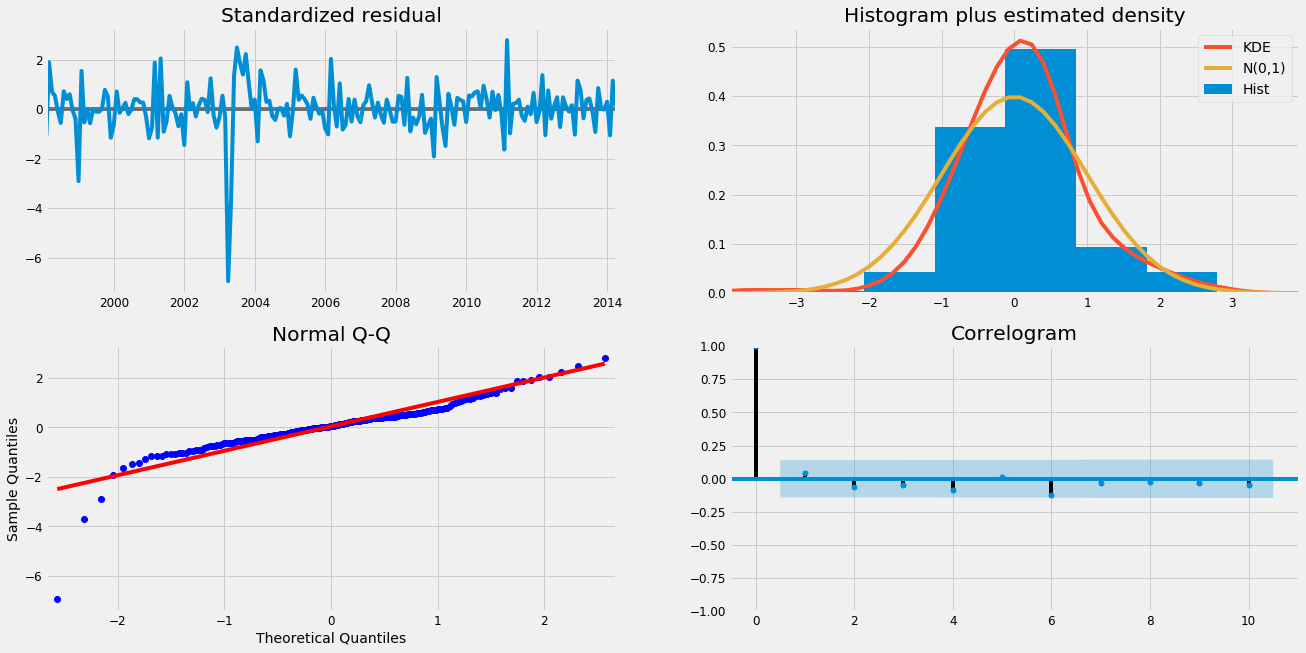

In [21]:
model_Auto_SARIMA_ext_var_month_fit.plot_diagnostics()
plt.show()

##### Validating Forecasts

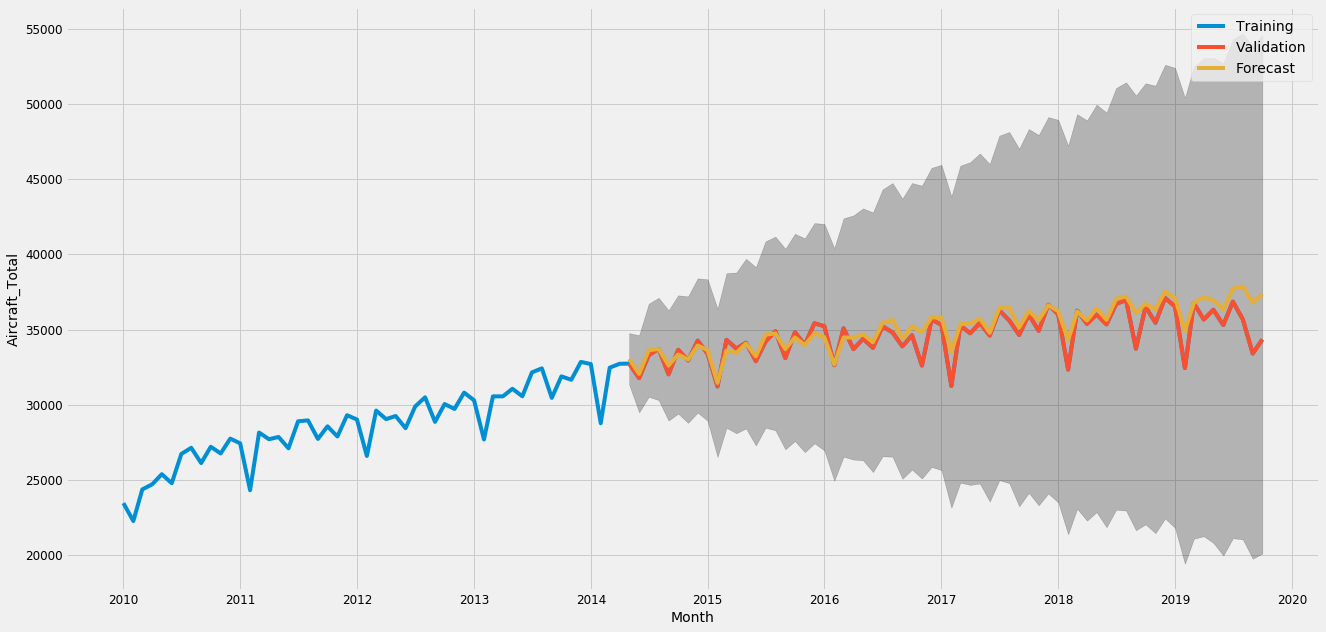

In [22]:
forecast_Auto_SARIMA_ext_var_month, forecast_Auto_SARIMA_ext_var_month_CI = model_Auto_SARIMA_ext_var_month_fit.predict(n_periods = len(valid), exogenous = exog_data_month_valid, return_conf_int = True)
forecast_Auto_SARIMA_ext_var_month = pd.DataFrame(forecast_Auto_SARIMA_ext_var_month, index = valid.index, columns = ['Forecast'])
plt.plot(data['2010':], label = 'Training')
plt.plot(valid, label = 'Validation')
plt.plot(forecast_Auto_SARIMA_ext_var_month, label = 'Forecast')
# Add confidence interval, optional
plt.fill_between(valid.index,
                 forecast_Auto_SARIMA_ext_var_month_CI[:, 0],
                 forecast_Auto_SARIMA_ext_var_month_CI[:, 1], color='k', alpha=.25)
plt.xlabel(data.index.name)
plt.ylabel(data.name)
plt.legend()
plt.show()

In [23]:
evaluate_forecast(valid, forecast_Auto_SARIMA_ext_var_month)

,R Squared,MSE,RMSE,MSLE,Mean Absolute Error,Median Absolute Error,MAPE,SMAPE,MAE%
0,0.531004,994053.296526,997.022215,0.000824,658.450094,356.180489,NaN,NaN,1.902974
